# Oceanum Otis wrapper demo

In [20]:
import os
import logging.config
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import oceantide
from oceantide import read_otis_netcdf, read_otis_binary
from oceantide.core.otis import read_otis_bin_h

from oncore.core import Grid
from oncore import LOGGING_CONFIG
from onotis import OtisAtlas, BathyFile, DEFAULT_CONS, SALFILE

In [2]:
logging.config.dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)

---
## Preamble

### Define grid

The oncore Grid object defines the model grid:

In [3]:
grid = Grid(x0=165, x1=180, y0=-48, y1=-34, dx=0.5, dy=0.5)
print(f"Grid: {grid}, Extension: ({grid.nx}, {grid.ny}), Resolution: ({grid.dx}, {grid.dy})")

Grid: <Grid x0=165 x1=180 y0=-48 y1=-34>, Extension: (31, 29), Resolution: (0.5, 0.5)


### Define bathy

The otis wrapper requires some supported bathy component with a`get` method which returns an xarray dataset with a specific convention. there are currently 4 different options:

* BathyFile
* BathyIntake
* BathyOntake
* BathyDatamesh

In [4]:
bathy = BathyFile(
    filename="/source/onotis/tests/test_files/bathy/gebco_subset.zarr",
    engine="zarr",
    zname="elevation",
    invert=True,
)
bathy

BathyFile(filename='/source/onotis/tests/test_files/bathy/gebco_subset.zarr', engine='zarr', xname='lon', yname='lat', zname='elevation', invert=True, grid=None)

2022-11-23 21:32:15,732 [INFO] onotis.components.bathy:	Get bathy data.
2022-11-23 21:32:15,751 [INFO] onotis.components.bathy:	Validate bathy dataset


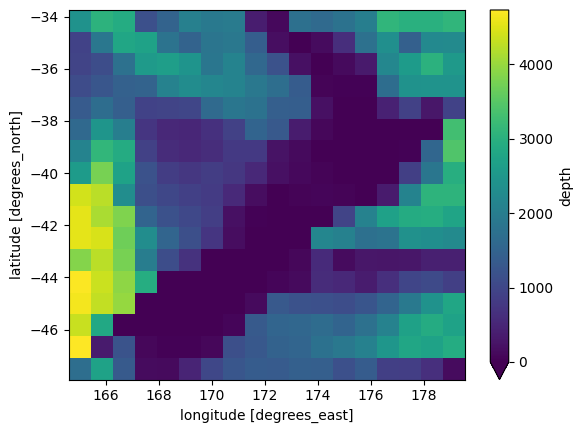

In [5]:
# View bathy

dset = bathy.get().sel(lon=slice(grid.x0, grid.x1), lat=slice(grid.y0, grid.y1))
p = dset.depth.plot(vmin=0, vmax=None)

---
## Model workflow

### Instantiate OtisAtlas wrapper

The OtisAtlas object uses gridded cons in [oceantide](https://github.com/oceanum/oceantide) zarr format such as the Atlas or any other appropriate zarr archive

In [6]:
oa = OtisAtlas(
    dataset_id="testrun",
    grid=grid,
    bathy=bathy,
    rootdir="/source/onotis/notebooks/rootdir",
    updir="/source/onotis/notebooks/updir",
    cons=DEFAULT_CONS,
    smooth_fac=None,
    hmin=2,
    bnd_namespace="tide",
    bnd_dataset_id="otis_tpxo9_atlas_v4_test",
    bnd_master_url="/source/onotis/tests/test_files/oceanum.yml",
    salfile=None,
    # salfile=SALFILE, # Use a local file to avoid slow transfer from bucket
)

2022-11-23 21:32:18,542 [INFO] onotis.onotis:	
<class 'onotis.onotis.OtisAtlas'>
rootdir: /source/onotis/notebooks/rootdir/testrun
extents: <Grid x0=165 x1=180 y0=-48 y1=-34>
res: 0.5 by 0.5
cons: ['m2', 's2', 'n2', 'k2', 'k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']
salfile: 
bathy: BathyFile(filename='/source/onotis/tests/test_files/bathy/gebco_subset.zarr', engine='zarr', xname='lon', yname='lat', zname='elevation', invert=True, grid=None)
bnd: tide.otis_tpxo9_atlas_v4_test



### Preprecess

The preprocess method sets up the model environment and creates the required input files

In [7]:
oa.preprocess()

2022-11-23 21:32:20,626 [INFO] onotis.onotis:	================================================================================
2022-11-23 21:32:20,628 [INFO] onotis.onotis:	Preprocessing model data for testrun
2022-11-23 21:32:20,629 [INFO] onotis.onotis:	================================================================================
2022-11-23 21:32:20,630 [INFO] onotis.onotis:	Setting environment
2022-11-23 21:32:20,633 [INFO] onotis.onotis:	Setting max RAM in /source/onotis/notebooks/rootdir/testrun/exe/run_param from system memory: 16487 Mb
2022-11-23 21:32:20,950 [INFO] onotis.onotis:	Creating bathy file /source/onotis/notebooks/rootdir/testrun/input/bathy.dat
2022-11-23 21:32:20,950 [INFO] onotis.components.bathy:	Get bathy data.
2022-11-23 21:32:20,956 [INFO] onotis.components.bathy:	Validate bathy dataset
2022-11-23 21:32:21,046 [INFO] onotis.onotis:	730 / 899 water points (81%)


If run successfully, preprocess with set up the environment with required input files in `{rootdir}/{dataset_id}` location:

In [8]:
print(oa.rootdir)
!ls ./rootdir/testrun/*

/source/onotis/notebooks/rootdir/testrun
./rootdir/testrun/bathy:

./rootdir/testrun/dat:

./rootdir/testrun/exe:
bhat_samp    Fwd_fac  makefile	mk_g_ll  reduce_B  rpx_to_rp  Sml_df	 Varest
data_cooker  Lat_lon  mkB	mk_grid  repX	   run_param  stats_rlz
Diffuse      Makedat  mkFrv	ob_eval  rlcX	   Scfac      Sumreps

./rootdir/testrun/input:
bathy.dat  h_boundary  model_boundary

./rootdir/testrun/otis_binary:

./rootdir/testrun/otis_netcdf:

./rootdir/testrun/out:

./rootdir/testrun/prm:
cf_difvar  Constituents

./rootdir/testrun/repx1:


### Check generated binary boundary file

The [read_otis_bin_h](https://github.com/oceanum/oceantide/blob/master/oceantide/core/otis.py#L283) function reads elevation binary file and returns an xarray dataset in Otis netcdf convention


In [9]:
dset_bnd = read_otis_bin_h(f"{Path(oa.rootdir) / 'input/h_boundary'}")
dset_bnd

<xarray.Dataset>
Dimensions:  (nc: 14, nx: 3, ny: 3)
Dimensions without coordinates: nc, nx, ny
Data variables:
    con      (nc) |S4 dask.array<chunksize=(14,), meta=np.ndarray>
    lon_z    (nx, ny) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    lat_z    (nx, ny) float64 dask.array<chunksize=(3, 3), meta=np.ndarray>
    hRe      (nc, nx, ny) float64 dask.array<chunksize=(14, 3, 3), meta=np.ndarray>
    hIm      (nc, nx, ny) float64 dask.array<chunksize=(14, 3, 3), meta=np.ndarray>
Attributes:
    type:     OTIS tidal elevation file
    title:    Oceantide tidal elevation from binary file

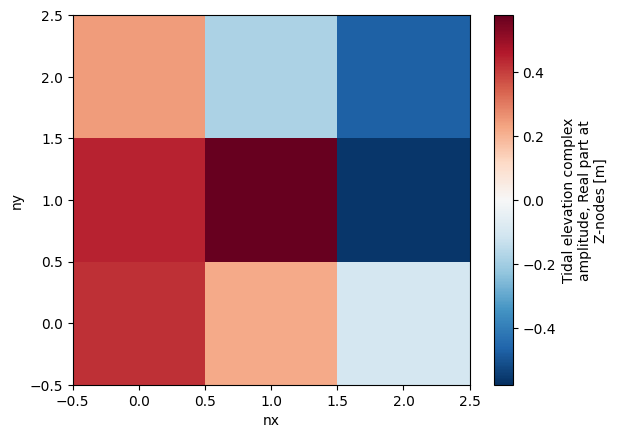

In [10]:
# Plot the real component of M2

cons = [c.decode().strip() for c in dset_bnd.con.values]
im2 = cons.index("m2")
h = dset_bnd.hRe.isel(nc=im2).transpose("ny", "nx").plot()

### Run

The run method executes the following model files:

* mk_grid
* ob_eval
* Fwd_fac

In [11]:
oa.run()

2022-11-23 21:33:16,989 [INFO] onotis.onotis:	================================================================================
2022-11-23 21:33:16,990 [INFO] onotis.onotis:	Running OSU model for testrun
2022-11-23 21:33:16,991 [INFO] onotis.onotis:	================================================================================
2022-11-23 21:33:16,992 [INFO] onotis.onotis:	Run mk_grid
2022-11-23 21:33:16,994 [INFO] onotis.execute:	You are running mkgrid for creating standard
2022-11-23 21:33:16,995 [INFO] onotis.execute:	OTIS grid using one of bathymetry DB or your
2022-11-23 21:33:16,996 [INFO] onotis.execute:	local bathymetry:
2022-11-23 21:33:16,997 [INFO] onotis.execute:	mk_grid usage:
2022-11-23 21:33:16,997 [INFO] onotis.execute:	mk_grid [-g<output_grid_name>]
2022-11-23 21:33:16,998 [INFO] onotis.execute:	[-G<GEBCO_bathy_name_with_path>]
2022-11-23 21:33:16,999 [INFO] onotis.execute:	[-S<Smith&Sandwell_bathy_name_with_path>]
2022-11-23 21:33:17,000 [INFO] onotis.execute:	[-l<loc

The main output are binary files with grid and cons for elevation and transport created in `{rootdir}/{dataset_id}`:

In [13]:
!ls rootdir/testrun/prm/grid
!ls rootdir/testrun/out/h0.df.out
!ls rootdir/testrun/out/h0.df.out

rootdir/testrun/prm/grid
rootdir/testrun/out/h0.df.out
rootdir/testrun/out/h0.df.out


### Postprocess

The postprocessing method executes the following tasks:

* Writes the binary output into Otis netcdf format
* Writes the binary output into Oceantide zarr format
* Uploads model data to the specified location which can be a cloud bucket

In [14]:
oa.postprocess()

2022-11-23 21:42:24,358 [INFO] onotis.onotis:	================================================================================
2022-11-23 21:42:24,360 [INFO] onotis.onotis:	Postprocessing model data for testrun
2022-11-23 21:42:24,361 [INFO] onotis.onotis:	================================================================================
2022-11-23 21:42:24,362 [INFO] onotis.onotis:	Writting zarr cons dataset: /source/onotis/notebooks/rootdir/testrun/testrun.zarr
2022-11-23 21:42:24,942 [INFO] onotis.onotis:	Packing Otis binary and netcdf output


/home/rguedes/.virtualenvs/onotis/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


2022-11-23 21:42:25,473 [INFO] onotis.onotis:	Uploading model to: /source/onotis/notebooks/updir/testrun/
2022-11-23 21:42:25,474 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/exe/run_param to /source/onotis/notebooks/updir/testrun/run_param
2022-11-23 21:42:25,475 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/input/h_boundary to /source/onotis/notebooks/updir/testrun/h_boundary
2022-11-23 21:42:25,476 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/otis_binary to /source/onotis/notebooks/updir/testrun/
2022-11-23 21:42:25,479 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/otis_netcdf to /source/onotis/notebooks/updir/testrun/
2022-11-23 21:42:25,482 [INFO] oncore.dataio:	        uploading file /source/onotis/notebooks/rootdir/testrun/testrun.zarr to /source/onotis/notebooks/updir/testrun/


---
## Check results

### Check mode output from native (binary) and postprocessed formats (netcdf and zarr)

In [23]:
# Read native Otis binary format into an oceantide dataset
dscon_binary = read_otis_binary("/source/onotis/notebooks/updir/testrun/otis_binary/Model_testrun")

# Read converted Otis netcdf format into an oceantide dataset
dscon_netcdf = read_otis_netcdf("/source/onotis/notebooks/updir/testrun/otis_netcdf/Model_testrun")

# Read converted oceantide zarr file into an oceantide dataset
dscon_zarr = xr.open_dataset("/source/onotis/notebooks/updir/testrun/testrun.zarr", engine="zarr", chunks={})

dscon_zarr

<xarray.Dataset>
Dimensions:  (con: 14, lat: 29, lon: 31)
Coordinates:
  * con      (con) <U4 'M2' 'S2' 'N2' 'K2' 'K1' ... 'MF' 'M4' 'MN4' 'MS4' '2N2'
  * lat      (lat) float64 -48.0 -47.5 -47.0 -46.5 ... -35.5 -35.0 -34.5 -34.0
  * lon      (lon) float64 165.0 165.5 166.0 166.5 ... 178.5 179.0 179.5 180.0
Data variables:
    dep      (lat, lon) float64 dask.array<chunksize=(29, 31), meta=np.ndarray>
    h        (con, lat, lon) complex128 dask.array<chunksize=(14, 29, 31), meta=np.ndarray>
    u        (con, lat, lon) complex128 dask.array<chunksize=(14, 29, 31), meta=np.ndarray>
    v        (con, lat, lon) complex128 dask.array<chunksize=(14, 29, 31), meta=np.ndarray>
Attributes:
    description:  Oceantide tidal constituents

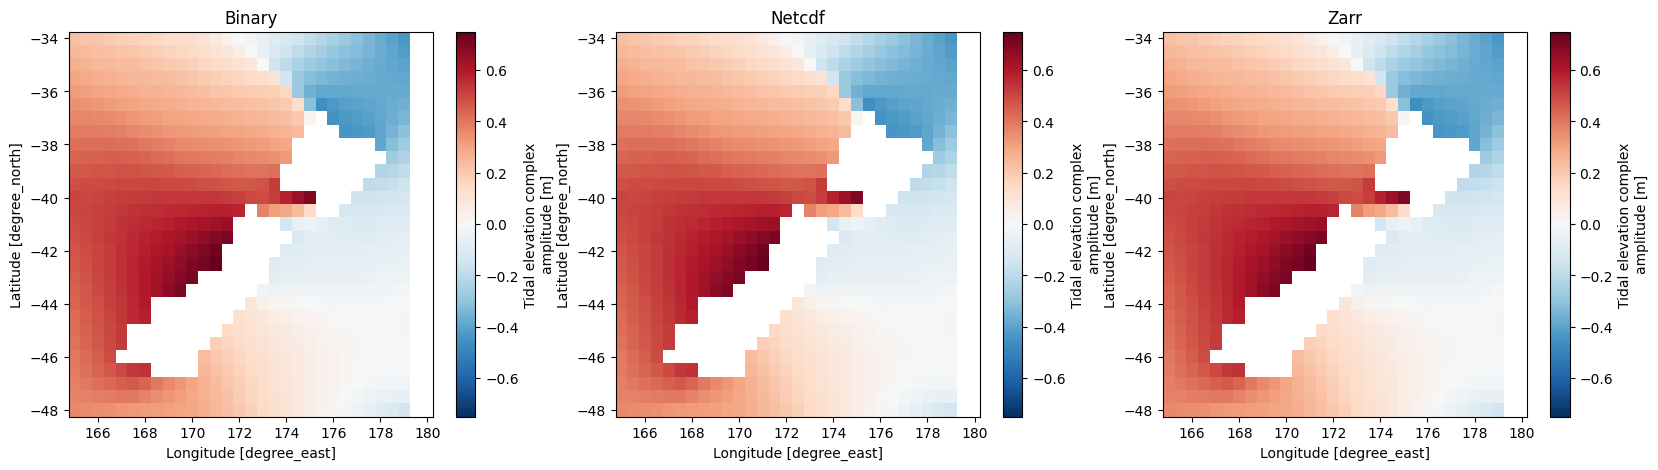

In [24]:
fig = plt.figure(figsize=(20, 5))

# Binary
ax = fig.add_subplot(131)
dscon_binary.h.real.isel(con=0).plot()
plt.title("Binary")

# Netcdf
ax = fig.add_subplot(132)
dscon_netcdf.h.real.isel(con=0).plot()
plt.title("Netcdf")

# Zarr
ax = fig.add_subplot(133)
dscon_zarr.h.real.isel(con=0).plot()
plt.title("Zarr");

### Use oceantide to calculate elevation and current timeseries from the full grid

In [41]:
%%time

times = pd.date_range(start="20220101T00", end="20220101T23", freq="1H")

dseta = dscon_zarr.tide.predict(times=times).load()
dseta

CPU times: user 268 ms, sys: 530 µs, total: 269 ms
Wall time: 257 ms


<xarray.Dataset>
Dimensions:  (lat: 29, lon: 31, time: 24)
Coordinates:
  * lat      (lat) float64 -48.0 -47.5 -47.0 -46.5 ... -35.5 -35.0 -34.5 -34.0
  * lon      (lon) float64 165.0 165.5 166.0 166.5 ... 178.5 179.0 179.5 180.0
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Data variables:
    dep      (lat, lon) float64 2.199e+03 2.605e+03 2.435e+03 ... 0.0 0.0
    h        (time, lat, lon) float64 0.3162 0.3207 0.3253 ... -0.3652 nan nan
    u        (time, lat, lon) float64 0.1269 0.1001 0.06828 ... 0.0231 nan nan
    v        (time, lat, lon) float64 -0.06959 -0.08463 -0.09821 ... nan nan
Attributes:
    description:  Tide elevation and currents time series

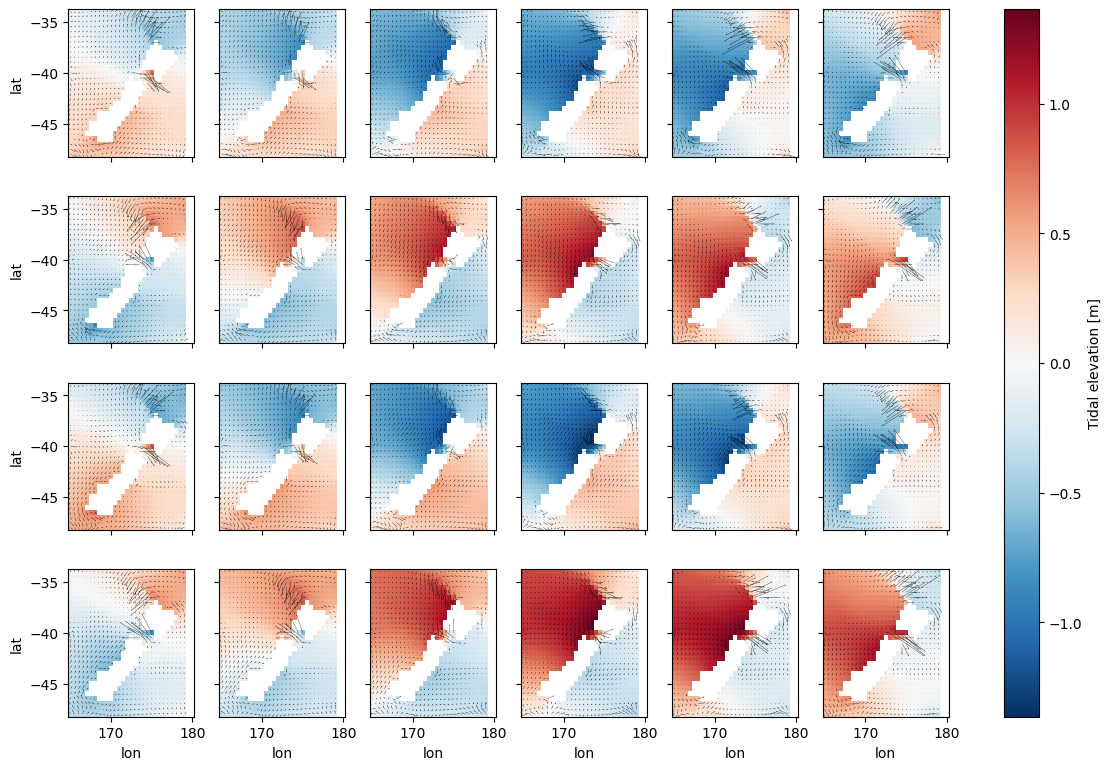

In [39]:
# Plot gridded output

p = dseta.h.plot(col="time", col_wrap=6, figsize=(12, 8));
for ind, ax in enumerate(p.axs.flat):
    ds = dseta.isel(time=ind)
    ax.quiver(ds.lon, ds.lat, ds.u, ds.v)
    ax.set_title("")

### Use oceantide to calculate 10-year hourly elevation and current timeseries from single point

In [54]:
%%time

times = pd.date_range(start="20220101T00", end="20320101T00", freq="1H")

df = dscon_zarr.sel(lat=-41, lon=174.6, method="nearest").load().tide.predict(times=times, time_chunk=None).to_dataframe()
df

CPU times: user 466 ms, sys: 93.3 ms, total: 559 ms
Wall time: 572 ms


,lat,lon,dep,h,u,v
time,,,,,,
2022-01-01 00:00:00,-41.0,174.5,120.0,0.156794,0.161699,-0.194946
2022-01-01 01:00:00,-41.0,174.5,120.0,0.188489,0.119706,-0.082525
2022-01-01 02:00:00,-41.0,174.5,120.0,0.174374,0.047794,0.052919
2022-01-01 03:00:00,-41.0,174.5,120.0,0.115691,-0.033064,0.173362
2022-01-01 04:00:00,-41.0,174.5,120.0,0.021002,-0.100271,0.245216
...,...,...,...,...,...,...
2031-12-31 20:00:00,-41.0,174.5,120.0,0.135208,-0.138026,0.231584
2031-12-31 21:00:00,-41.0,174.5,120.0,0.136756,-0.143317,0.204535
2031-12-31 22:00:00,-41.0,174.5,120.0,0.112305,-0.116664,0.130695


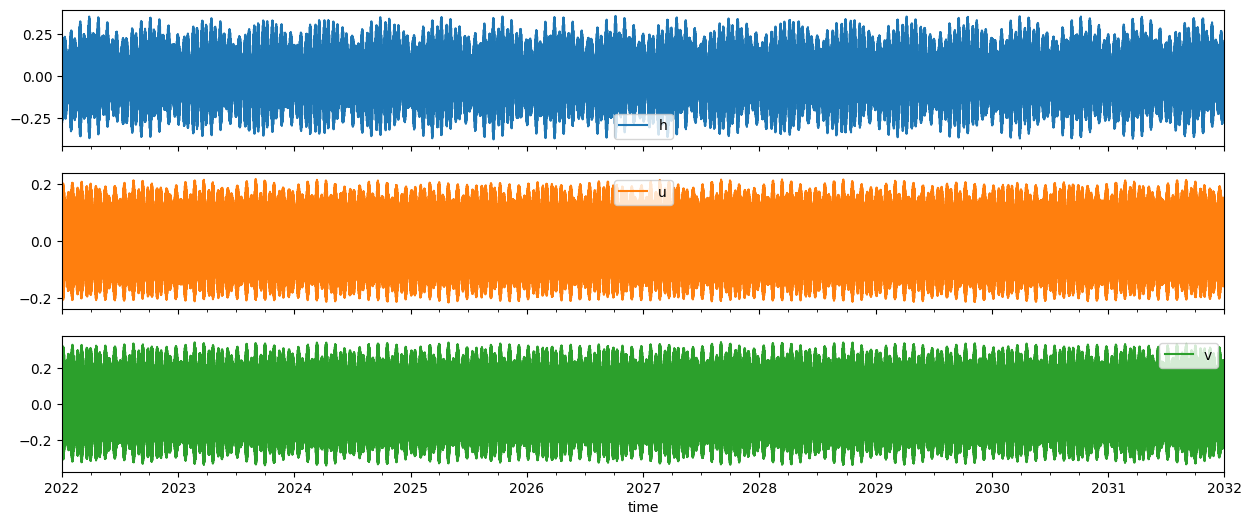

In [51]:
df[["h", "u", "v"]].plot(subplots=True, figsize=(15, 6));

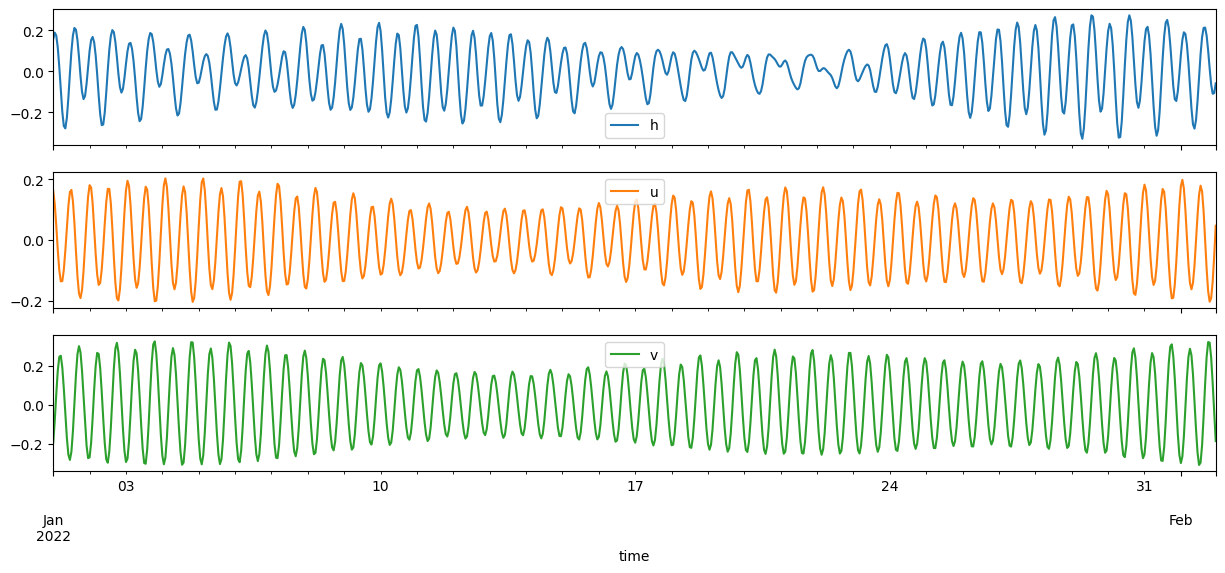

In [53]:
df[["h", "u", "v"]].loc["20220101": "20220201"].plot(subplots=True, figsize=(15, 6));